In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [2]:
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [3]:
labels_file = "https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels21.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

classes = np.array(classes)

In [4]:
x_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2")
])
x_model.build([None, 300, 300, 3])

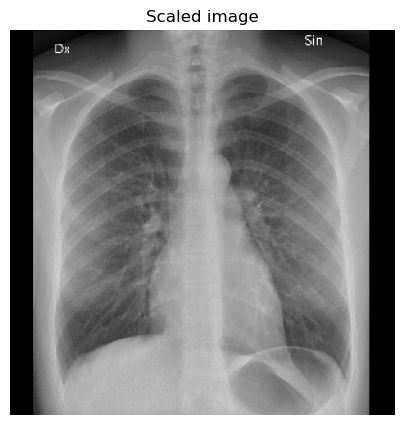

In [25]:
image_name = "xray2"

images_for_test_map = {
    "xray": "https://www.drugs.com/health-guide/images/ddca3f92-4b8e-4672-bb6b-f3594ad4e304.jpg",
    "xray2": "https://upload.wikimedia.org/wikipedia/commons/a/a1/Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg",
    "human": "https://www.ohchr.org/sites/default/files/styles/hero_image_2/public/2021-07/Ethiopia-UN0418425.jpg?itok=7wJB8CbZ",
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, 300, False, 300)
show_image(image, 'Scaled image')

In [26]:
predictions = x_model(image)
result = classes[np.argmax(predictions)]
print(np.argmax(predictions), result)

9647 radiogram, radiograph, shadowgraph, skiagraph, skiagram


In [22]:
probabilities = tf.nn.softmax(x_model(image)).numpy()

In [23]:
probabilities
top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
top_5

array([14726,  8000, 14769, 14720,  5503])

In [24]:
for i, item in enumerate(top_5):
    class_index = item
    line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
    print(line)

(1) 14726 - Tuareg: 0.10294186323881149
(2) 8000 - khimar: 0.08524750173091888
(3) 14769 - Yemeni: 0.07571647316217422
(4) 14720 - Sudanese: 0.0528908334672451
(5) 5503 - chador, chadar, chaddar, chuddar: 0.051043689250946045
